# Segmenting Buildings using Deep Learning

In [4]:
from IPython.display import clear_output

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

import matplotlib.pyplot as plt

from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import imageio

import cv2

import pandas as pd

from pycocotools.coco import COCO

import os
import sys
import time


In [32]:
import wget
import zipfile


if not os.path.exists("./dataset.zip"):  # Check if the file exists
    url = "https://www.dropbox.com/scl/fi/u3plfspdkxpxgcqt2jvkw/dataset.zip?rlkey=z82kloxfxv5jwq8k1r91bwu38&dl=1"
    filename = wget.download(url)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640)),
    transforms.CenterCrop((640, 640)),
])

class MyDataset(Dataset):
    def __init__(self, image_folder, annotation_file):
        self.coco = COCO(annotation_file)
        self.image_folder = image_folder
        self.image_ids = self.coco.getImgIds()

    def __getitem__(self, index):
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_folder, img_info['file_name'])
        img = imageio.imread(img_path)
        img = transform(img)

        # Initialize a mask for all categories in the image with zeros
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        # Load the segmentation masks for each instance in the image
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            # Check if 'segmentation' is in polygon format or RLE
            if type(ann['segmentation']) == list:
                # If it's a list, assume it's polygons and convert to mask
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    mask |= self.coco.annToMask(ann)  # Use annToMask for polygons
            else:
                # If it's not a list, treat it as RLE
                mask |= self.coco.annToMask(ann)  # Directly use RLE to create mask

        # Optionally, to handle multi-class segmentation, you could accumulate masks for each class separately

        # Convert the mask to a tensor
        mask = torch.as_tensor(mask, dtype=torch.int64)

        return {"images": img, "masks": mask}

    def __len__(self):
        return len(self.image_ids)

In [ ]:
dataset = MyDataset("./train/", "./train/_annotations.coco.json")

loading annotations into memory...
Done (t=2.95s)
creating index...
index created!


torch.Size([3, 640, 640]) torch.Size([640, 640])


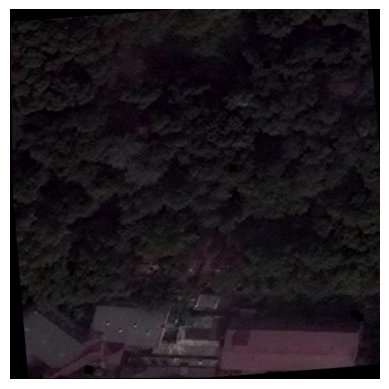

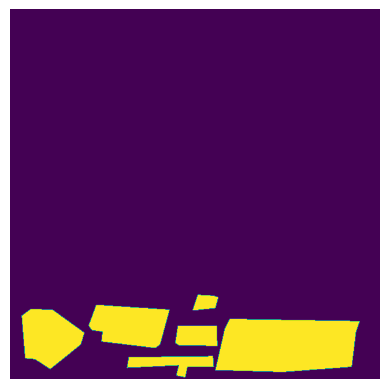

In [ ]:
n = torch.randint(0, len(dataset), (1,)).item()

sample_image = dataset[n]["images"]
sample_image_mask = dataset[n]["masks"]
print(sample_image.shape, sample_image_mask.shape)

sample_image_numpy = sample_image.permute(1, 2, 0).cpu().numpy()
sample_image_mask_numpy = sample_image_mask.numpy()


# Display the image
plt.imshow(sample_image_numpy)
plt.axis('off')  # Hide the axis
plt.show()

# Display the image
plt.imshow(sample_image_mask_numpy)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
batch_size = 4
shuffle = True
num_workers = 2

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


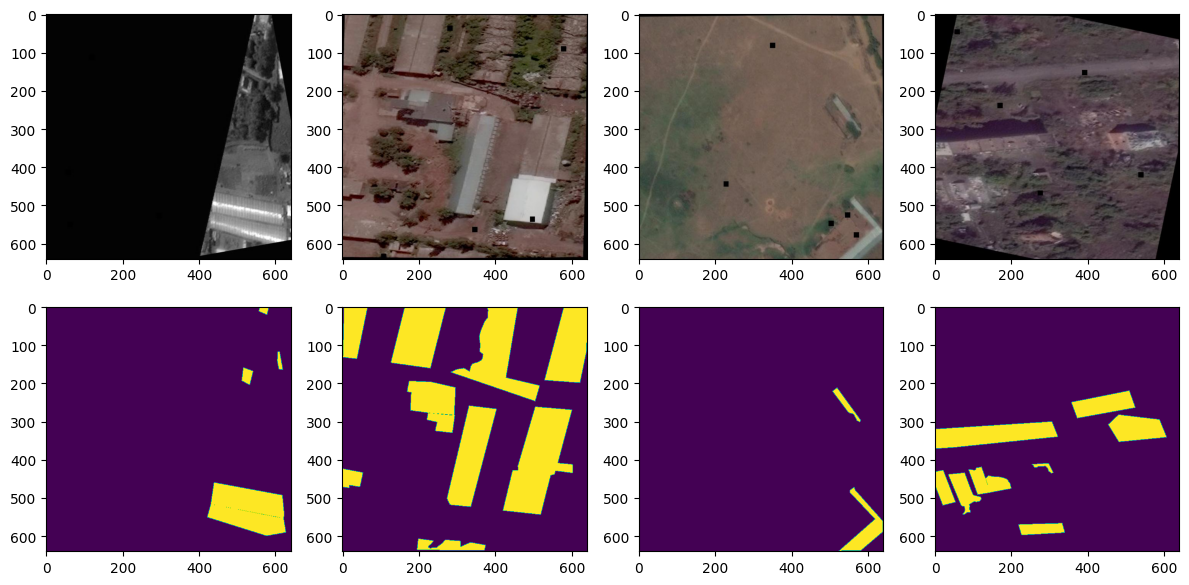

In [ ]:
batch = next(iter(data_loader))

# Extract images and masks from the batch
batch_images = batch["images"]
batch_masks = batch["masks"]

batch_size = batch_images.size(0)  # Get the batch size

fig, axs = plt.subplots(2, batch_size, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    if i < batch_size:
        ax.imshow(batch_images[i].permute(1, 2, 0))
    else:
        ax.imshow(batch_masks[i - batch_size])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Training

In [ ]:
def process_image(image):
    # TOOD: Transfer this to transforms to enhance training speed
    """Image should be in the format of (H, W, C). And the values are integers from 0 to 255"""


    gray_img = cv2.cvtColor((image.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2).astype(np.float16) / 255
#     gradient_direction = np.arctan2(sobel_y, sobel_x) * (180 / np.pi).astype(np.float32)

    # Not using Canny because it includes a ton of noise, and we can't blur the image as it will make it harder
    # to define building edges which are crucial to segment them.
#     canny = cv2.Canny((gray_img * 255).astype(np.uint8), threshold1=100, threshold2=200).astype(np.float32) / 255


    # The best results and most defining edges got from using gradient magnitude with the grayscale image
    mask_ratio = 0.4
    return gray_img.astype(np.float16) / 255 * (1 - mask_ratio) + gradient_magnitude * mask_ratio

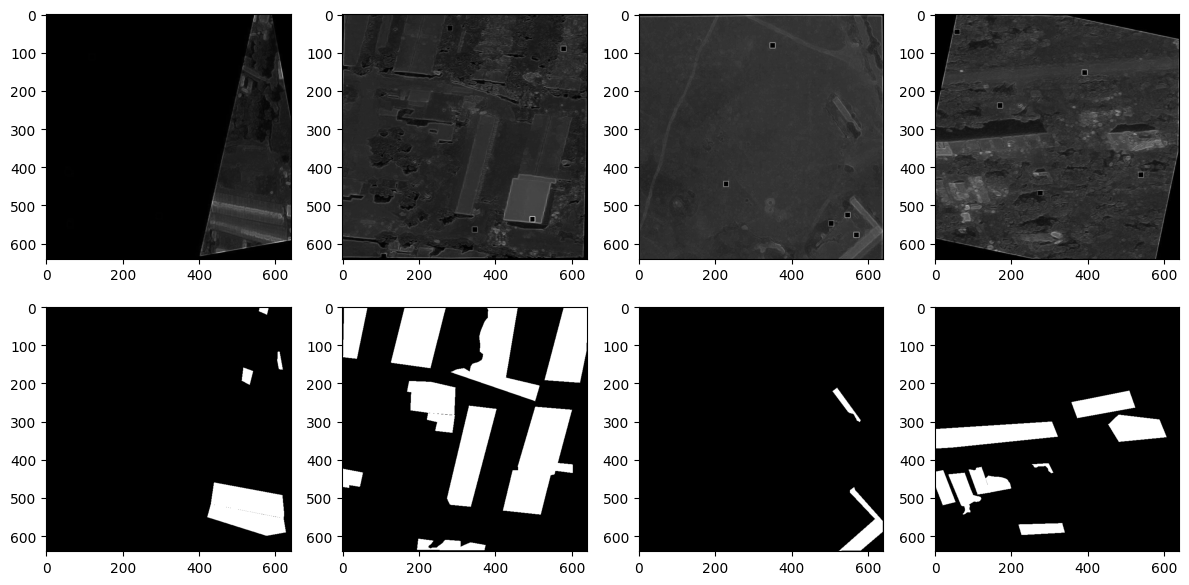

In [ ]:
batch_size = batch_images.size(0)  # Get the batch size

fig, axs = plt.subplots(2, batch_size, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    if i < batch_size:
        ax.imshow(process_image(batch_images[i].permute(1, 2, 0)), cmap='gray')
    else:
        ax.imshow(batch_masks[i - batch_size], cmap='gray')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
